<a href="https://colab.research.google.com/github/GuysBarash/Genetic-programing-with-DEAP/blob/master/evolutionarty_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install DEAP
pass

In [0]:
import random
import operator

import numpy as np
import pandas as pd

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from datetime import datetime
from deap.tools import History

from IPython.display import display, HTML
import matplotlib.pyplot as plt

# Generate Data

In [0]:
MUX_SELECT_LINES = 3
MUX_IN_LINES = 2 ** MUX_SELECT_LINES
MUX_TOTAL_LINES = MUX_SELECT_LINES + MUX_IN_LINES

def if_then_else(condition, out1, out2):
    return out1 if condition else out2

# input : [A0 A1 A2 D0 D1 D2 D3 D4 D5 D6 D7] for a 8-3 mux
inputs = [[0] * MUX_TOTAL_LINES for i in range(2 ** MUX_TOTAL_LINES)]
outputs = [None] * (2 ** MUX_TOTAL_LINES)

for i in range(2 ** MUX_TOTAL_LINES):
    value = i
    divisor = 2 ** MUX_TOTAL_LINES
    # Fill the input bits
    for j in range(MUX_TOTAL_LINES):
        divisor /= 2
        if value >= divisor:
            inputs[i][j] = 1
            value -= divisor

    # Determine the corresponding output
    indexOutput = MUX_SELECT_LINES
    for j, k in enumerate(inputs[i][:MUX_SELECT_LINES]):
        indexOutput += k * 2 ** j
    outputs[i] = inputs[i][indexOutput]

datacols = [f'bx{idx}' for idx in range(MUX_TOTAL_LINES)]
labelcol = 'LABEL'
datadf = pd.DataFrame(columns=datacols,
                      index=range(2 ** MUX_TOTAL_LINES),
                      data=inputs)
datadf[labelcol] = outputs

In [144]:
top_n = 14
display(datadf.head(14))
print("")
print(f"Displaying top {top_n} out of {len(datadf)}")

,bx0,bx1,bx2,bx3,bx4,bx5,bx6,bx7,bx8,bx9,bx10,LABEL
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,1,0,1,0
6,0,0,0,0,0,0,0,0,1,1,0,0
7,0,0,0,0,0,0,0,0,1,1,1,0
8,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,1,0



Displaying top 14 out of 2048


# Defining evolution parameters

Legal nodes in tree

In [0]:
pset = gp.PrimitiveSet("MAIN", MUX_TOTAL_LINES, "IN")
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.not_, 1)
pset.addPrimitive(if_then_else, 3)
pset.addTerminal(1)
pset.addTerminal(0)

Evolution parameters

In [146]:
history = History()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Support functions

In [0]:
evaluation_counter = 0

def individual_to_function(individual):
    return toolbox.compile(expr=individual)


def apply_function_to_df(func, dataset=None):
  if dataset is None:
    dataset =  datadf[datacols]
  results = datadf[datacols].apply(lambda r: func(*r.values), axis=1)
  return results


def evalMultiplexer(individual):
    global evaluation_counter
    evaluation_counter += 1
    func = individual_to_function(individual)
    results = apply_function_to_df(func)
    fitness = (results == datadf[labelcol]).sum()
    max_score = len(datadf)
    fitness_score = fitness / max_score
    return fitness_score,

In [0]:
# random.seed(10)
population_size = 25
number_of_generations = 25

toolbox.register("evaluate", evalMultiplexer)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)



pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Decorate the variation operators
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)
history.update(pop)

# Evolution part

In [149]:
print("Starting evolution.")
start_time = datetime.now()
_, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.1, ngen=number_of_generations, stats=stats, halloffame=hof)
record = stats.compile(pop)
duration = datetime.now() - start_time
print("Run concluded.")
print("Evaluations commited: {}".format(evaluation_counter))
print("Run time: {}".format(duration))
winner_creature = hof.items[0]
winner_function = individual_to_function(winner_creature)

Starting evolution.
gen	nevals	avg     	std      	min     	max    
0  	25    	0.510781	0.0476662	0.429688	0.59375
1  	13    	0.555312	0.0337963	0.4375  	0.59375
2  	12    	0.576875	0.0220617	0.53125 	0.59375
3  	18    	0.575625	0.0232513	0.53125 	0.59375
4  	22    	0.581875	0.0226557	0.53125 	0.625  
5  	23    	0.58875 	0.0305292	0.515625	0.625  
6  	21    	0.606875	0.0260258	0.53125 	0.625  
7  	23    	0.5925  	0.0321496	0.53125 	0.625  
8  	18    	0.59125 	0.0366252	0.5     	0.625  
9  	16    	0.61375 	0.023184 	0.5625  	0.625  
10 	22    	0.598125	0.0288179	0.5625  	0.625  
11 	21    	0.596875	0.0299739	0.53125 	0.625  
12 	18    	0.589375	0.0357727	0.5     	0.625  
13 	22    	0.5975  	0.0319546	0.546875	0.625  
14 	22    	0.595   	0.031225 	0.53125 	0.625  
15 	18    	0.60625 	0.0268823	0.546875	0.625  
16 	18    	0.600625	0.0283257	0.53125 	0.625  
17 	20    	0.5925  	0.0336341	0.5     	0.625  
18 	22    	0.58875 	0.035    	0.5     	0.625  
19 	22    	0.59125 	0.0326798	0.53125 	0

# Analyze results

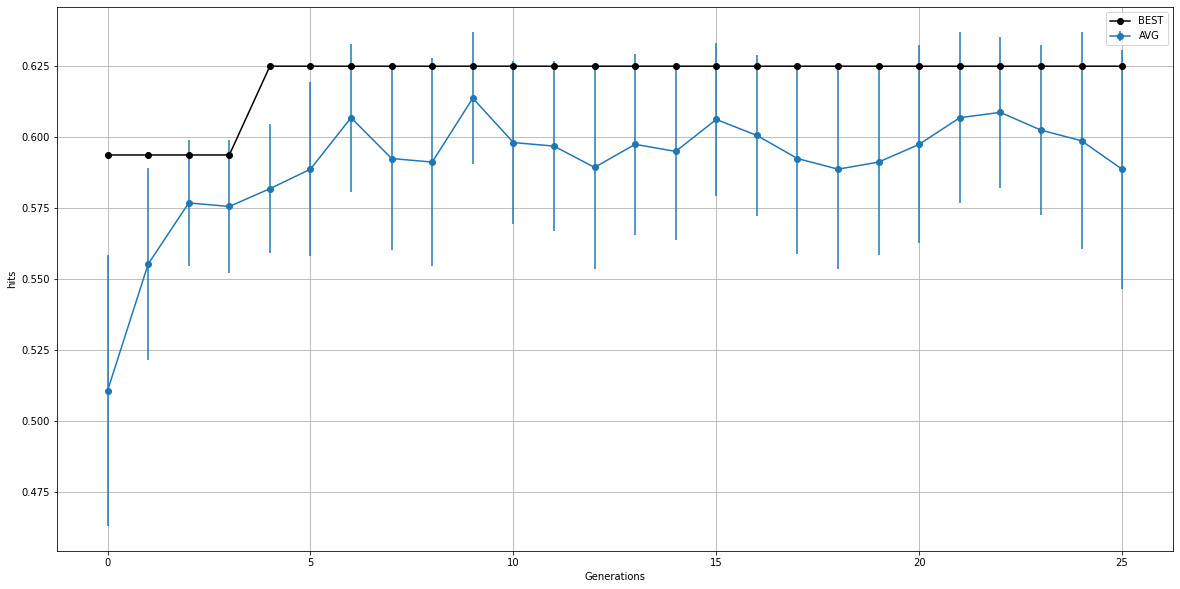

In [150]:
generations_idx = logbook.select('gen')
generations_avg = logbook.select('avg')
generations_std = logbook.select('std')
generations_max = logbook.select('max')

plt.figure(figsize=(20,10))
plt.errorbar(generations_idx,generations_avg, yerr=generations_std, fmt='-o',label='AVG')
# plt.plot(generations_idx,generations_avg, '-o',label='AVG')
plt.plot(generations_max,'-o',label='BEST',  color='black')
plt.grid()
plt.legend()
plt.xlabel('Generations')
plt.ylabel('hits')
_ = plt.plot()

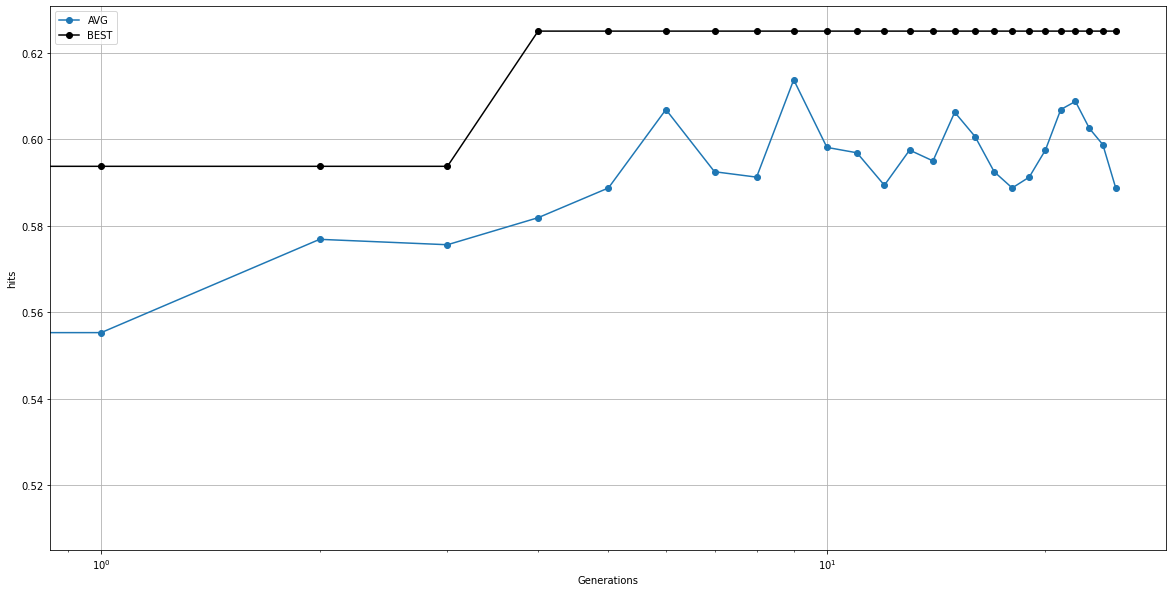

In [151]:
generations_idx = logbook.select('gen')
generations_avg = logbook.select('avg')
generations_std = logbook.select('std')
generations_max = logbook.select('max')

plt.figure(figsize=(20,10))
# plt.errorbar(generations_idx,avg, yerr=std, fmt='-o',label='AVG')
plt.plot(generations_idx,generations_avg,'-o',label='AVG')
plt.plot(generations_max,'-o',label='BEST',  color='black')
plt.grid()
plt.legend()
plt.xscale('log')
plt.xlabel('Generations')
plt.ylabel('hits')
_ = plt.plot()

In [0]:
predictions = apply_function_to_df(winner_function).astype(np.int64)
true_results = datadf[labelcol]

In [153]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score

scoring_sr = pd.DataFrame(dtype=np.float, columns=['value'])
scoring_sr.loc['Accuracy','value'] = accuracy_score(true_results, predictions)
scoring_sr.loc['Recall','value'] = recall_score(true_results, predictions)
scoring_sr.loc['precision','value'] = precision_score(true_results, predictions)
scoring_sr.loc['F0.25','value'] = fbeta_score(true_results, predictions,beta=0.25)

display(scoring_sr)



,value
Accuracy,0.625000
Recall,0.750000
precision,0.600000
F0.25,0.607143
